## Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Preparing the data

In [2]:
data = pd.read_csv('./dataset/iris.csv') # Load the data using pandas

Get a glimpse of the data

In [3]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's get some information of the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [6]:
data.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [7]:
print(f'Number of columns: {len(data.columns)}')

Number of columns: 5


In [8]:
print(f'Number of rows: {len(data)}')

Number of rows: 150


Let's see the data description

In [5]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Let's see the correlation of each columns except for the `species`

In [10]:
data.drop(['species'], axis=1).corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


Let's see if the data contains missing values

In [14]:
data.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Let's see if the data contains outliers

In [16]:
def get_outliers_indices(col: pd.DataFrame, threshold=3):
    data_arr = np.asarray(col.values.tolist())
    z_scores = (data_arr - np.mean(data_arr)) / np.std(data_arr)
    
    indices = np.nonzero(np.abs(z_scores) > threshold)[0]
    
    return indices

In [17]:
for col in data.drop(['species'], axis=1):
    outliers_indices = get_outliers_indices(data[col])
    print(f'There are {len(outliers_indices)} in {col}')

There are 0 in sepal_length
There are 1 in sepal_width
There are 0 in petal_length
There are 0 in petal_width


Let's see how many species there is in the data

In [32]:
data['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

## Preprocessing the data

Since there are no missing values and categorical data, we can continue to handle outliers

In [19]:
for col in data.drop(['species'], axis=1):
    outliers_indices = get_outliers_indices(data[col])
    data: pd.DataFrame = data.drop(outliers_indices)
    print(f'Removed {len(outliers_indices)} outliers, from {col}')

Removed 0 outliers, from sepal_length
Removed 0 outliers, from sepal_width
Removed 0 outliers, from petal_length
Removed 0 outliers, from petal_width


Since the data is already scaled, we don't have to scale it again. So let's continue to the Dimensionality Reduction. We'll use PCA method

In [26]:
def apply_pca(X: np.ndarray, n_dimensions=2):
    # Get the mean along the first axis
    mean_X = np.mean(X)
    
    # Get the X centered
    X_center = X - mean_X
    
    # Create the covariance matrix
    cov = np.cov(X_center.T)
    
    # Create the eigenvalues and eigenvector using the covariance matrix
    eigenvalues, eigenvector = np.linalg.eig(cov)
    
    # Transpose the eigenvector
    eigenvector = eigenvector.T
    
    # Get the sorted indices reversed
    indices = np.argsort(eigenvalues)[::-1]
    
    # Reorder the eigenvector
    eigenvector = eigenvector[indices]
    
    # Get the desired features based on the n_dimensions
    features = eigenvector[:n_dimensions]
    
    return np.dot(X_center, features.T)

In [25]:
# Turn the data's values into a numpy array
data_properties = np.asarray(data.drop(['species'], axis=1).values.tolist())

# Reduced dimension values
pca_values = apply_pca(data_properties)

# Make a new Data Frame using the previous values
pca_data = pd.DataFrame(pca_values, columns=['Col1', 'Col2'])
pca_data.head()

,Col1,Col2
0,-2.698349,-0.350640
1,-2.732449,0.142165
2,-2.906446,0.112910
3,-2.764003,0.287656
4,-2.742564,-0.356187


## Making the model

In [27]:
X = pca_values

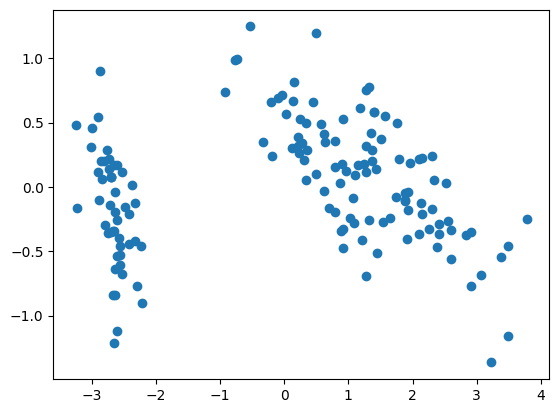

In [29]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

I think it's supposed to be divided into 3 clusters. Let's make the visualization function first

In [30]:
def plot_cluster(X: np.ndarray, centroids: np.ndarray, labels: np.ndarray):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X')
    plt.show()

Now let's actually make the model

In [42]:
class KMeans:
    def __init__(self, k, max_iters=300) -> None:
        self.k = k
        self.max_iters = max_iters
        self._centroids = None
        self._labels = None
        self._inertia = None
    
    def _assign_labels(self, X: np.ndarray, centroids: np.ndarray):
        # Calculate the distances using the euclidean distance
        distances = np.sqrt((X - centroids[:, np.newaxis]) ** 2).sum(axis=2)
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X: np.ndarray, labels: np.ndarray):
        centroids = np.zeros((self.k, X.shape[1]))

        # Find the mean
        for i in range(self.k):
            centroids[i] = np.mean(X[labels == i], axis=0)
        
        return centroids
    
    def _calc_inertia(self, X: np.ndarray, centroids: np.ndarray, labels: np.ndarray):
        # Sum of squared distances
        inertia = 0
        
        for i in range(self.k):
            # Get the data points in this cluster
            cluster_points = X[labels == i]
            inertia += np.sum((cluster_points - centroids[i]) ** 2)
        
        return inertia
    
    def fit(self, X: np.ndarray, visualize=False):
        # Initialize centroids in random data points
        centroids = X[np.random.choice(X.shape[0], self.k)]
        labels = self._assign_labels(X, centroids)
        
        for i in range(self.max_iters):
            labels = self._assign_labels(X, centroids)
            new_centroids = self._update_centroids(X, labels)
            
            # If the centroids does not change at all
            if np.all(centroids == new_centroids):
                if visualize:
                    print(f'Last Iteration {i + 1}')
                    plot_cluster(X, centroids, labels)
                break
            
            if visualize and i % 5 == 0:
                print(f'Iteration {i + 1}')
                plot_cluster(X, centroids, labels)
            
            # Set the centroids to the new centroids
            centroids = new_centroids
        
        self._centroids = centroids
        self._labels = labels
        self._inertia = self._calc_inertia(X, centroids, labels)

Iteration 1


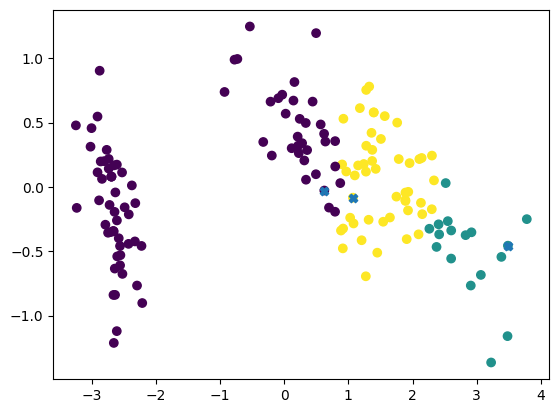

Iteration 6


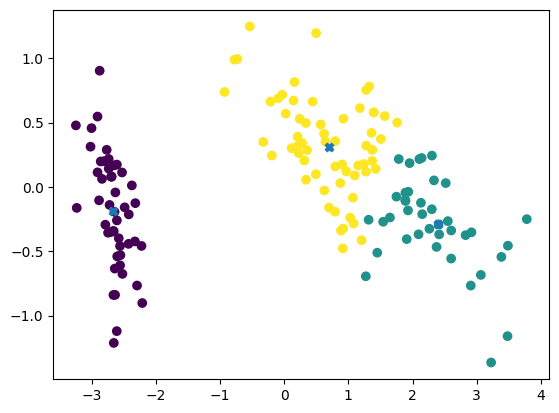

Last Iteration 8


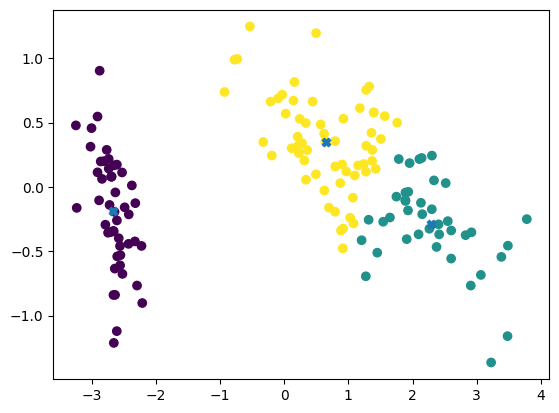

In [45]:
model = KMeans(3) # Since we have 3 species
model.fit(X, visualize=True)

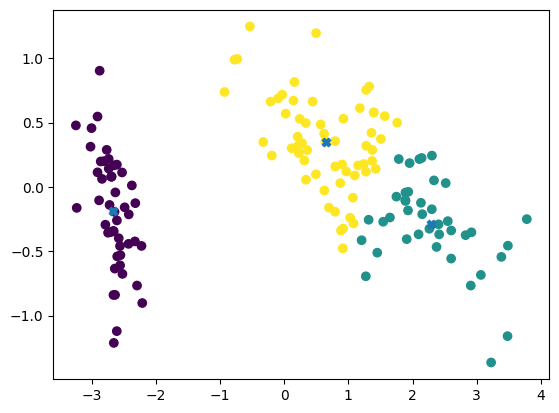

In [46]:
plot_cluster(X, model._centroids, model._labels)

## Evaluating the model

In [47]:
def elbow_method(test_model: KMeans, max_k=10):
    # Sum of Squared Distances
    ssd = list()
    
    for k in range(1, max_k + 1):
        test_model = KMeans(k)
        test_model.fit(X)
        ssd.append(test_model._inertia)
        
    plt.plot(range(1, max_k + 1), ssd, marker='o')
    plt.xlabel('Value of k')
    plt.ylabel('Sum of Squared Distances')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


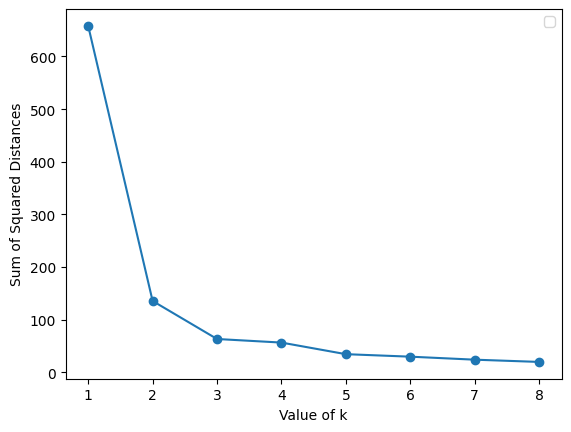

In [49]:
elbow_method(model, max_k=8)

Let's assign the label to the main DataFrame

In [50]:
data['label'] = model._labels

In [51]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species,label
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
